## Librerias

In [138]:
import generators as gen 
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import chisquare, pearsonr, kstest

## Funciones auxiliares

In [139]:
""" Funciones para plot """
def plot_3d(points, title=''):
    fig = plt.figure(figsize=(8, 6))
    ax = fig.add_subplot(111, projection='3d')
    ax.scatter(points[:, 0], points[:, 1], points[:, 2], s=1, alpha=0.6)
    ax.set_xlabel("x")
    ax.set_ylabel("y")
    ax.set_zlabel("z")
    ax.set_title(title)
    plt.show()

def plot_pairs(points, title=''):
    plt.figure(figsize=(8, 6))
    plt.scatter(points[:, 0], points[:, 1], s=1, alpha=0.6)
    plt.xlabel("x")
    plt.ylabel("y")
    plt.title(title)
    plt.grid(True)
    plt.show()

def plot_histogram(values, bins=50, title=''):
    plt.figure(figsize=(8, 6))
    plt.hist(values, bins=bins, density=True, alpha=0.7)
    plt.xlabel("Value")
    plt.ylabel("Density")
    plt.title(title)
    plt.grid(True)
    plt.show()


""" Funciones que permiten el análisis estadístico """

def generate_d_points(rng, d):
    n = len(rng) // d
    return np.array(rng[:n*d]).reshape((n, d))


def chi_square_uniformity(rng, n=10000, bins=60):
    values = np.array([next(rng) for _ in range(n)])
    counts, _ = np.histogram(values, bins=bins, range=(0, 1))
    expected = np.full(bins, n / bins)
    if np.any(expected < 5):
        raise ValueError("Some expected frequencies are below 5. Consider reducing the number of bins.")
    stat, p_value = chisquare(counts, expected)
    return stat, p_value

def correlation_test(rng, n=10000, lag=1):
    values = np.array([next(rng) for _ in range(n)])
    x = values[:-lag]
    y = values[lag:]
    corr, p_value = pearsonr(x, y)
    return corr, p_value


def ks_test_uniformity(rng, n=10000):
    values = np.array([next(rng) for _ in range(n)])
    stat, p_value = kstest(values, 'uniform', args=(0, 1))
    return stat, p_value

## Tests estadísticos


In [140]:
N_test = [10000, 20000, 30000, 40000, 50000, 60000]
bins = [60, 100, 150, 200, 250, 300]
chi_tests: list[tuple[str, float, float]] = []
autocorr_tests: list[tuple[str, float, float]] = []
ks_test: list[tuple[str, float, float]] = []

print("Resultados del test Chi-cuadrado para uniformidad:")
for n_test in N_test:
    print(f"\nTest con {n_test} muestras:")
    for bin in bins:
        print(f"\nTomando {bin} bins:")
        genCong = gen.genCongruencial(2605, 16807, 0, 2**31 - 1)
        genXor = gen.XorShift(2463534242)
        genMersenne = gen.Mersenne(5489)

        lcg_rng = (x for x in ([next(genCong) for _ in range(n_test)]))
        xor_rng = (x for x in ([next(genXor) for _ in range(n_test)]))
        mt_rng = (x for x in ([next(genMersenne) for _ in range(n_test)]))

        print("\nChi-cuadrado (Uniformidad):")
        for name, rng in zip(["LCG", "XorShift", "Mersenne"], [lcg_rng, xor_rng, mt_rng]):
            stat, p = chi_square_uniformity(rng, n=n_test, bins=bin)
            chi_tests.append((name, stat, p))
            print(f"{name}: stat = {stat:.4f}, p-value = {p:.4f}")


print("\nPromedio de p-values para cada generador en el test Chi-cuadrado:")
avg_p_values = {}
for name, stat, p in chi_tests:
    if name not in avg_p_values:
        avg_p_values[name] = []
    avg_p_values[name].append(p)

for name, p_values in avg_p_values.items():
    avg_p = np.mean(p_values)
    print(f"\nPromedio de p-value para {name}: {avg_p:.4f}")


print("\nResultados del test de autocorrelación:")
for n in N_test:
    genCong = gen.genCongruencial(2605, 16807, 0, 2**31 - 1)
    genXor = gen.XorShift(2463534242)
    genMersenne = gen.Mersenne(5489)

    lcg_rng = (x for x in ([next(genCong) for _ in range(n_test)]))
    xor_rng = (x for x in ([next(genXor) for _ in range(n_test)]))
    mt_rng = (x for x in ([next(genMersenne) for _ in range(n_test)]))

    print(f"\nAutocorrelación para {n} muestras:")
    for name, rng in zip(["LCG", "XorShift", "Mersenne"], [lcg_rng, xor_rng, mt_rng]):
        r, p_value = correlation_test(rng, n=n, lag=1)
        autocorr_tests.append((name, r, p_value))
        print(f"{name}: r = {r:.4f}")

print("\nPromedio de correlación para cada generador en el test de autocorrelación:")
avg_corr_values = {}
for name, r, p in autocorr_tests:
    if name not in avg_corr_values:
        avg_corr_values[name] = []
    avg_corr_values[name].append(r)
for name, r_values in avg_corr_values.items():
    avg_r = np.mean(r_values)
    print(f"\nPromedio de r para {name}: {avg_r:.4f}")


print("\nResultados del test de Kolmogorov-Smirnov para uniformidad:")
for n in N_test:
    genCong = gen.genCongruencial(2605, 16807, 0, 2**31 - 1)
    genXor = gen.XorShift(2463534242)
    genMersenne = gen.Mersenne(5489)

    lcg_rng = (x for x in ([next(genCong) for _ in range(n)]))
    xor_rng = (x for x in ([next(genXor) for _ in range(n)]))
    mt_rng = (x for x in ([next(genMersenne) for _ in range(n)]))

    print(f"\nKolmogorov-Smirnov para {n} muestras:")
    for name, rng in zip(["LCG", "XorShift", "Mersenne"], [lcg_rng, xor_rng, mt_rng]):
        stat, p_value = ks_test_uniformity(rng, n=n)
        ks_test.append((name, stat, p_value))
        print(f"{name}: stat = {stat:.4f}, p-value = {p_value:.4f}")
        
print("\nPromedio de p-values para cada generador en el test de Kolmogorov-Smirnov:")
avg_p_values_ks = {}
for name, stat, p in ks_test:
    if name not in avg_p_values_ks:
        avg_p_values_ks[name] = []
    avg_p_values_ks[name].append(p)
for name, p_values in avg_p_values_ks.items():
    avg_p = np.mean(p_values)
    print(f"\nPromedio de p-value para {name}: {avg_p:.4f}")

Resultados del test Chi-cuadrado para uniformidad:

Test con 10000 muestras:

Tomando 60 bins:

Chi-cuadrado (Uniformidad):
LCG: stat = 58.6400, p-value = 0.4887
XorShift: stat = 74.7680, p-value = 0.0808
Mersenne: stat = 51.6560, p-value = 0.7403

Tomando 100 bins:

Chi-cuadrado (Uniformidad):
LCG: stat = 112.2800, p-value = 0.1707
XorShift: stat = 130.5600, p-value = 0.0184
Mersenne: stat = 91.5600, p-value = 0.6897

Tomando 150 bins:

Chi-cuadrado (Uniformidad):
LCG: stat = 178.2200, p-value = 0.0514
XorShift: stat = 181.0700, p-value = 0.0378
Mersenne: stat = 162.8900, p-value = 0.2063

Tomando 200 bins:

Chi-cuadrado (Uniformidad):
LCG: stat = 229.0400, p-value = 0.0709
XorShift: stat = 218.3600, p-value = 0.1651
Mersenne: stat = 219.8800, p-value = 0.1480

Tomando 250 bins:

Chi-cuadrado (Uniformidad):
LCG: stat = 261.8000, p-value = 0.2763
XorShift: stat = 269.8000, p-value = 0.1744
Mersenne: stat = 271.5000, p-value = 0.1565

Tomando 300 bins:

Chi-cuadrado (Uniformidad):
LCG: 

## Grafico en 2 y 3 Dimensiones, Histograma de valores

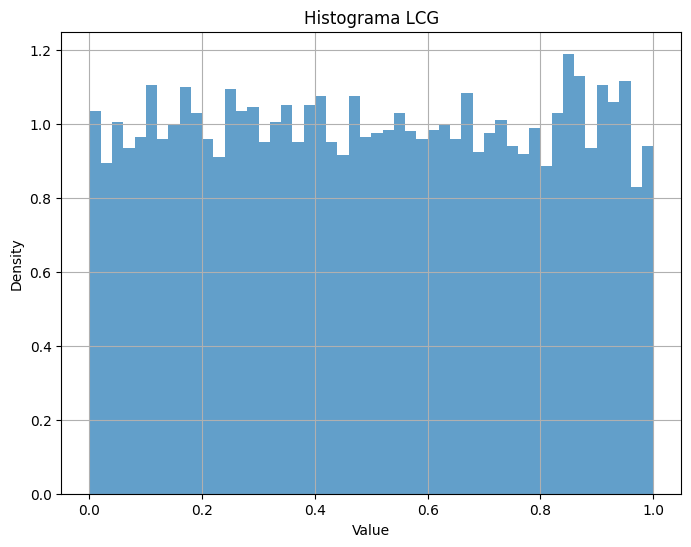

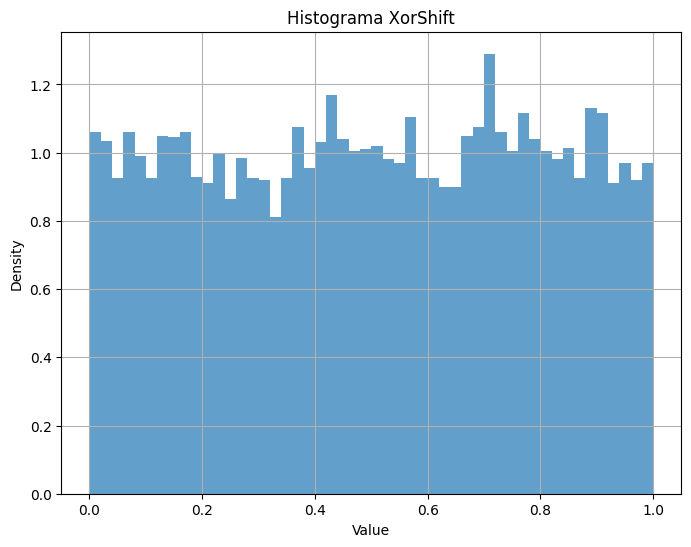

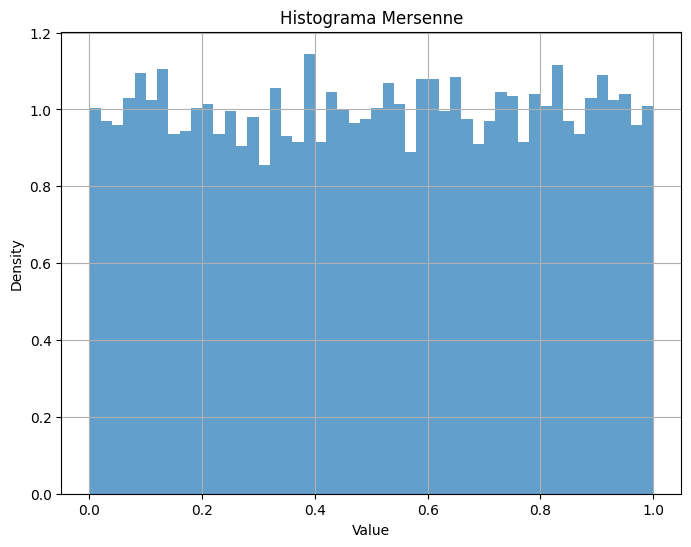

Puntos LCG generados:


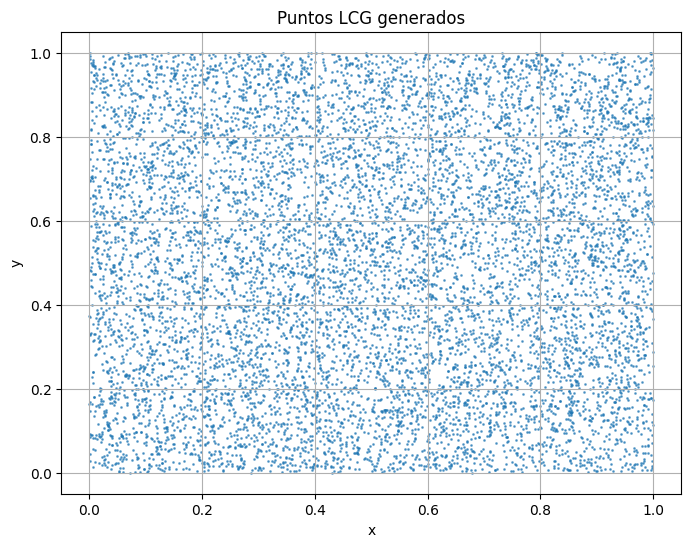

Puntos XorShift generados:


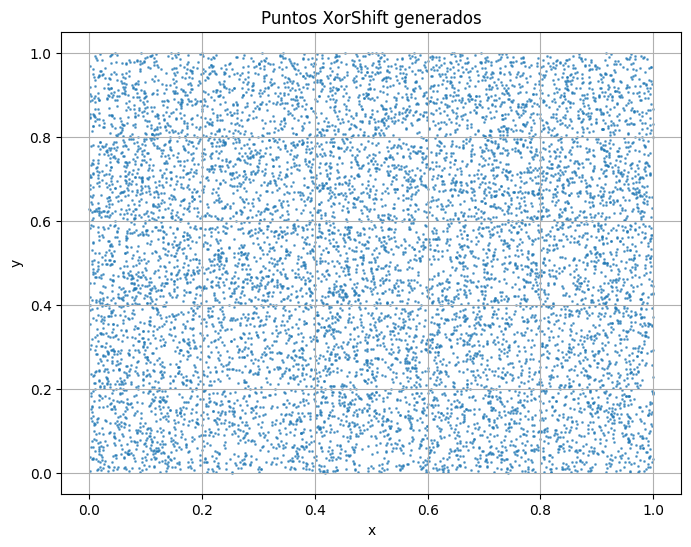

Puntos Mersenne generados:


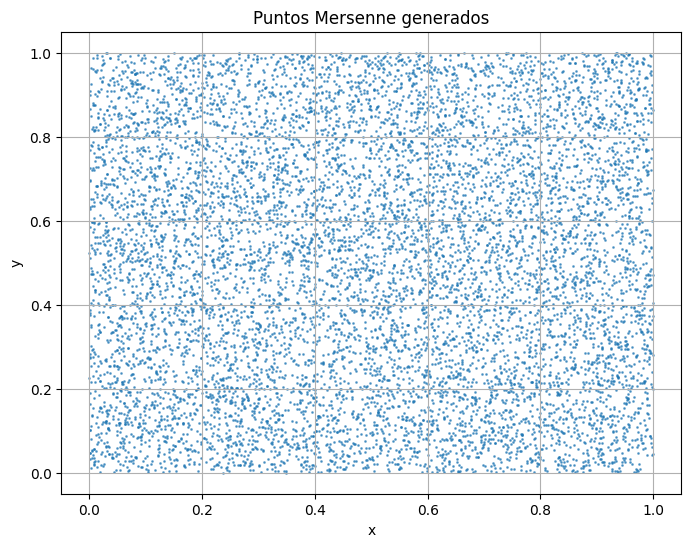

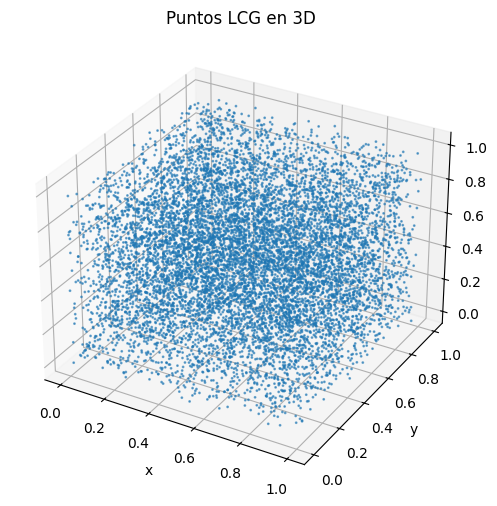

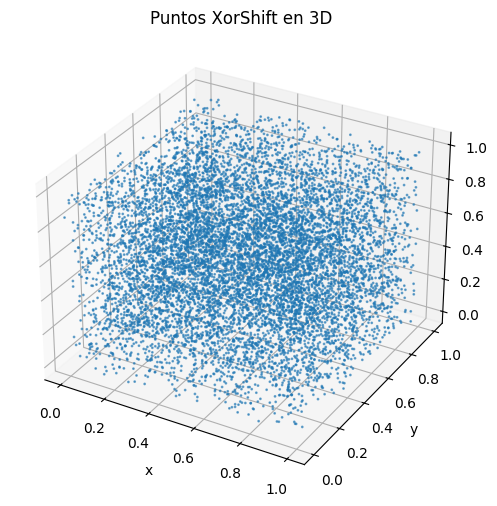

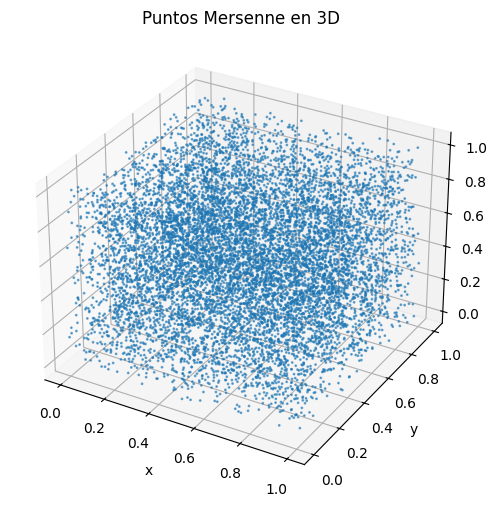

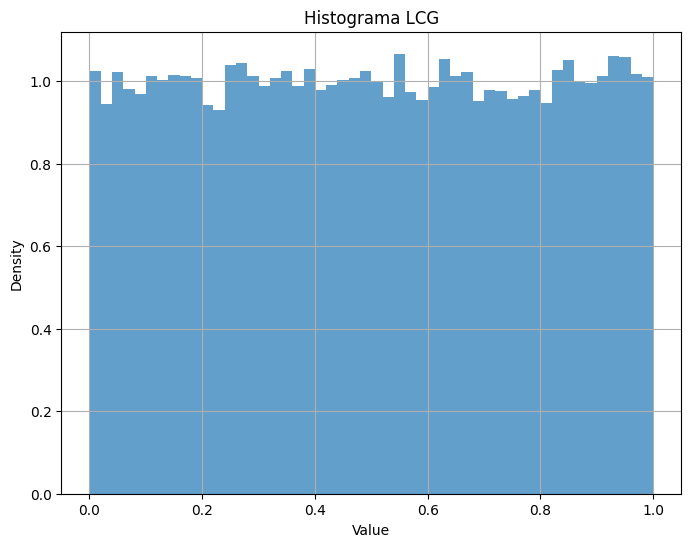

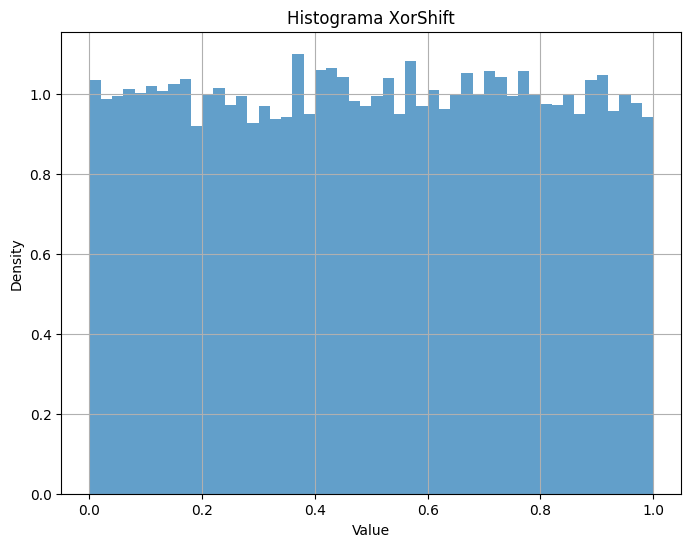

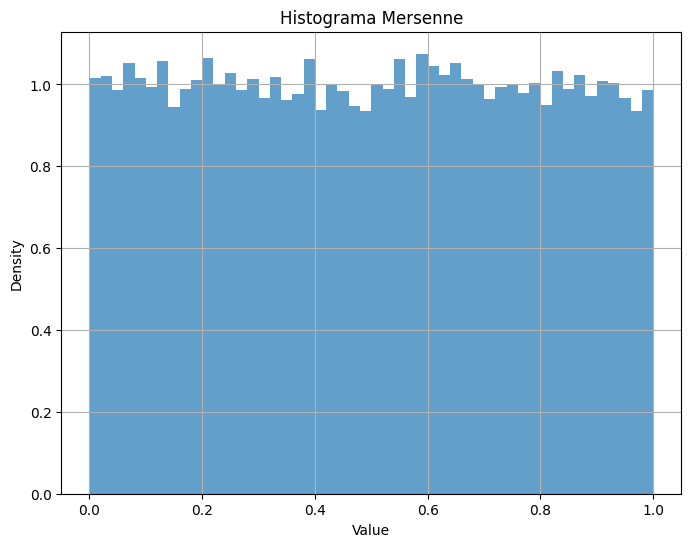

Puntos LCG generados:


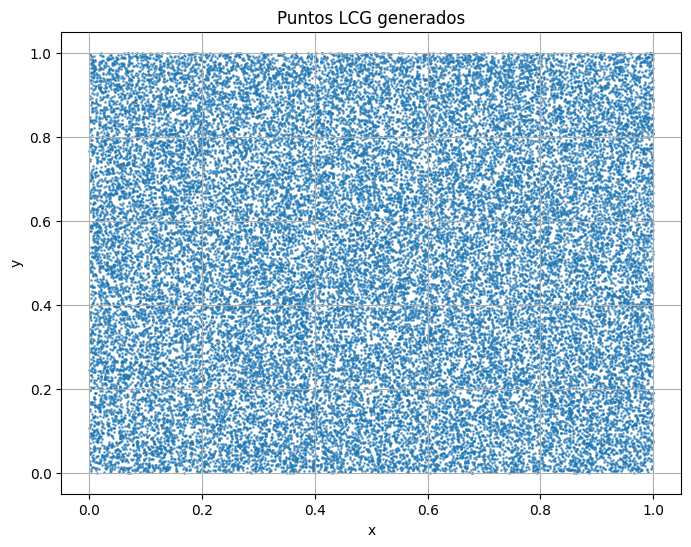

Puntos XorShift generados:


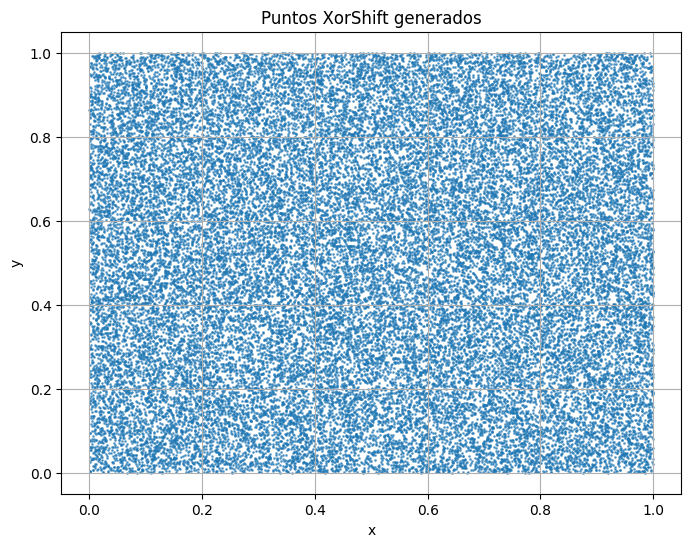

Puntos Mersenne generados:


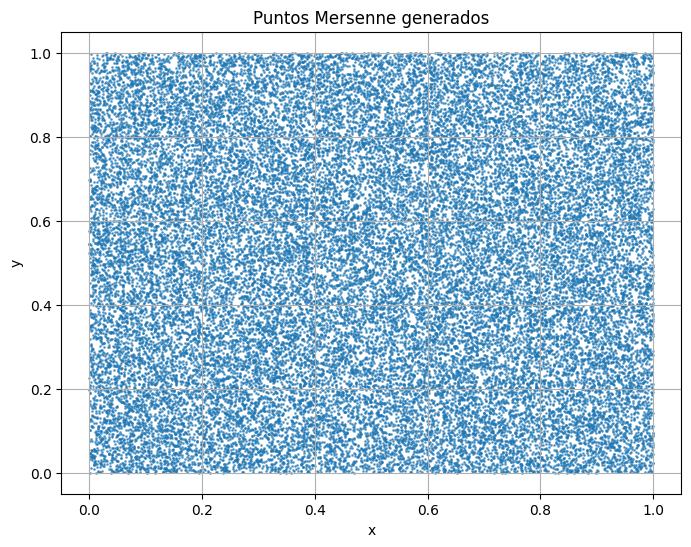

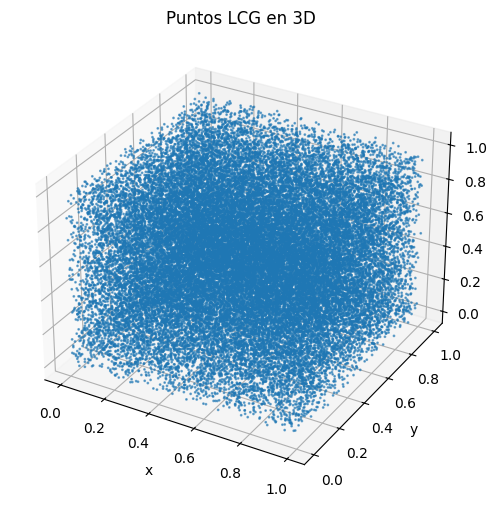

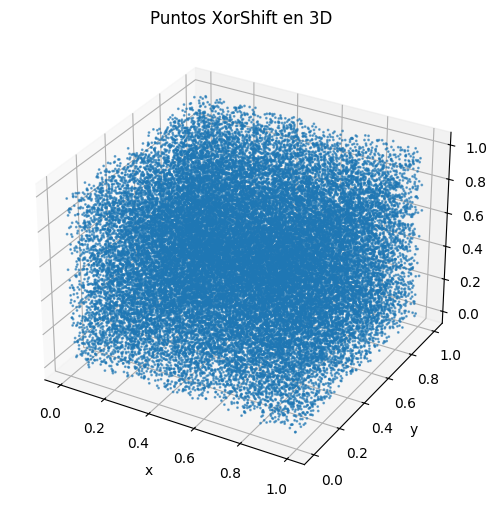

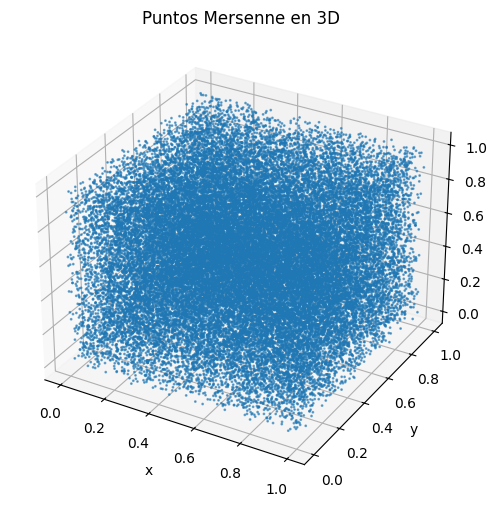

In [141]:
points_per_dim = [10000, 40000]

for points in points_per_dim:
    # Histograma de valores generados por los RNGs
    N = points
    genCong = gen.genCongruencial(2605, 16807, 0, 2**31 - 1)
    genXor = gen.XorShift(2463534242)
    genMersenne = gen.Mersenne(5489)

    lcg_rng = [next(genCong) for _ in range(N)]
    xor_rng = [next(genXor) for _ in range(N)]
    mt_rng = [next(genMersenne) for _ in range(N)]

    plot_histogram(lcg_rng, bins=50, title='Histograma LCG')
    plot_histogram(xor_rng, bins=50, title='Histograma XorShift')
    plot_histogram(mt_rng, bins=50, title='Histograma Mersenne')


    # Generación de puntos en 2D y 3D

    N = points * 2

    genCong = gen.genCongruencial(2605, 16807, 0, 2**31 - 1)
    genXor = gen.XorShift(2463534242)
    genMersenne = gen.Mersenne(5489)
    

    lcg_rng = [next(genCong) for _ in range(N)]
    xor_rng = [next(genXor) for _ in range(N)]
    mt_rng = [next(genMersenne) for _ in range(N)]
    

    points_lcg = generate_d_points((lcg_rng), 2)
    points_xor = generate_d_points((xor_rng), 2)
    points_mt = generate_d_points((mt_rng), 2)
    


    print("Puntos LCG generados:")
    plot_pairs(points_lcg, title='Puntos LCG generados')

    print("Puntos XorShift generados:")
    plot_pairs(points_xor, title='Puntos XorShift generados')

    print("Puntos Mersenne generados:")
    plot_pairs(points_mt, title='Puntos Mersenne generados')


    N = points * 3

    lcg_rng = [next(genCong) for _ in range(N)]
    xor_rng = [next(genXor) for _ in range(N)]
    mt_rng = [next(genMersenne) for _ in range(N)]
    

    points_lcg = generate_d_points((lcg_rng), 3)
    points_xor = generate_d_points((xor_rng), 3)
    points_mt = generate_d_points((mt_rng), 3)
    


    plot_3d(points_lcg, title='Puntos LCG en 3D')
    plot_3d(points_xor, title='Puntos XorShift en 3D')
    plot_3d(points_mt, title='Puntos Mersenne en 3D')
    